In [346]:
# Importing our dataset
import pandas


# Two Ways : API Call or Local Import

# API Call this way our dataset will alwayys be up to date

from urllib.request import urlopen
import json

url = 'https://opendata.muenchen.de/api/3/action/datastore_search?resource_id=40094bd6-f82d-4979-949b-26c8dc00b9a7'  
data_json = json.loads(urlopen(url).read())

dataset_raw = data_json['result']['records']
print(dataset_raw[:3]) # Show 3 first rows

dataset_api = pandas.DataFrame(dataset_raw)
dataset_api = dataset_api.drop('_id', axis = 1) # remove the '_id' column since pandas.DataFrame introduce its own "id" column 

print("\n\n------------Dataset API head :------------\n")
print(dataset_api.head())

# Local Import

path = './dataset/monatszahlen2112_verkehrsunfaelle.csv'
dataset_local = pandas.read_csv(path) 

print("\n\n------------Dataset Local head :------------\n")
print(dataset_local.head())

[{'_id': 1, 'MONATSZAHL': 'Alkoholunfälle', 'AUSPRAEGUNG': 'insgesamt', 'JAHR': 2021, 'MONAT': '202101', 'WERT': None, 'VORJAHRESWERT': 28, 'VERAEND_VORMONAT_PROZENT': None, 'VERAEND_VORJAHRESMONAT_PROZENT': None, 'ZWOELF_MONATE_MITTELWERT': None}, {'_id': 2, 'MONATSZAHL': 'Alkoholunfälle', 'AUSPRAEGUNG': 'insgesamt', 'JAHR': 2021, 'MONAT': '202102', 'WERT': None, 'VORJAHRESWERT': 40, 'VERAEND_VORMONAT_PROZENT': None, 'VERAEND_VORJAHRESMONAT_PROZENT': None, 'ZWOELF_MONATE_MITTELWERT': None}, {'_id': 3, 'MONATSZAHL': 'Alkoholunfälle', 'AUSPRAEGUNG': 'insgesamt', 'JAHR': 2021, 'MONAT': '202103', 'WERT': None, 'VORJAHRESWERT': 27, 'VERAEND_VORMONAT_PROZENT': None, 'VERAEND_VORJAHRESMONAT_PROZENT': None, 'ZWOELF_MONATE_MITTELWERT': None}]


------------Dataset API head :------------

       MONATSZAHL AUSPRAEGUNG  JAHR   MONAT  WERT  VORJAHRESWERT  \
0  Alkoholunfälle   insgesamt  2021  202101   NaN             28   
1  Alkoholunfälle   insgesamt  2021  202102   NaN             40   
2  Al

In [400]:
# Data Cleaning

# NB : I will work with local_dataset since it's mentioned in the Challenge

dataset = dataset_local.drop(dataset_local.columns[5:], axis=1) # Keep only the first 5 important columns

print(dataset.head())

dataset = dataset.dropna() # Remove all NaN values

print("\n\n------------Removing NaN Values------------\n")
print(dataset.head())

data_sum = dataset[dataset['MONAT'] == 'Summe'] # We might need the Sum information later on so I decided to keep it in data_sum
dataset = dataset[dataset['MONAT'] != 'Summe'] # Remove all the sum from our dataset

print("\n\n------------Sum Data------------\n")
print(data_sum.head())
print("\n\n------------New Dataset------------\n")
print(dataset.head())

# calculate duplicates
dups = dataset.duplicated()
# Checking for duplicates values since rows that have identical data are probably useless,
# If not dangerously misleading during model evaluation.
if dups.any():
    print(dataset[dups])
else:
    print("\nNo duplicates values !")


       MONATSZAHL AUSPRAEGUNG  JAHR   MONAT  WERT
0  Alkoholunfälle   insgesamt  2021  202101   NaN
1  Alkoholunfälle   insgesamt  2021  202102   NaN
2  Alkoholunfälle   insgesamt  2021  202103   NaN
3  Alkoholunfälle   insgesamt  2021  202104   NaN
4  Alkoholunfälle   insgesamt  2021  202105   NaN


------------Removing NaN Values------------

        MONATSZAHL AUSPRAEGUNG  JAHR   MONAT   WERT
12  Alkoholunfälle   insgesamt  2020   Summe  430.0
13  Alkoholunfälle   insgesamt  2020  202001   28.0
14  Alkoholunfälle   insgesamt  2020  202002   40.0
15  Alkoholunfälle   insgesamt  2020  202003   27.0
16  Alkoholunfälle   insgesamt  2020  202004   26.0


------------Sum Data------------

        MONATSZAHL AUSPRAEGUNG  JAHR  MONAT   WERT
12  Alkoholunfälle   insgesamt  2020  Summe  430.0
25  Alkoholunfälle   insgesamt  2019  Summe  434.0
38  Alkoholunfälle   insgesamt  2018  Summe  398.0
51  Alkoholunfälle   insgesamt  2017  Summe  409.0
64  Alkoholunfälle   insgesamt  2016  Summe  301.0

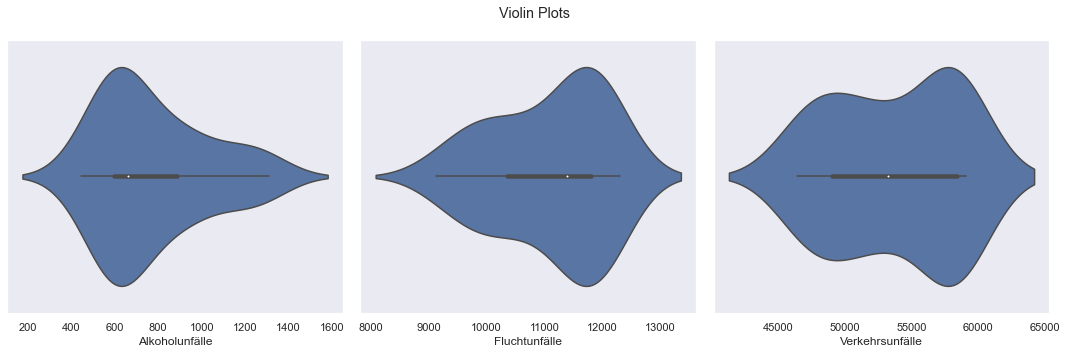

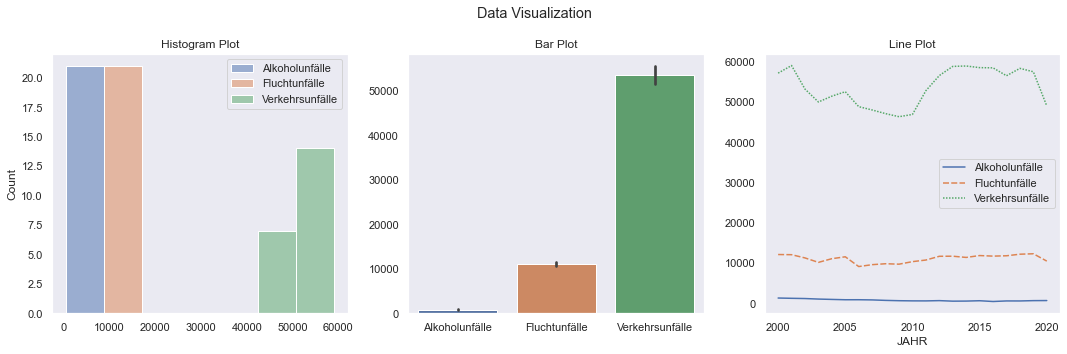

In [401]:
# Data Visualization

import seaborn as sns
from matplotlib import pyplot as plt

# Let's try to visualize the number of accident each year by Category
# For that we will be using our data_sum

plot_data = data_sum.groupby(['JAHR','MONATSZAHL']) # Let's group by Year and Category first
#print(plot_data.head())
#print("\n\n")
plot_data = plot_data.sum() # Let's sum so we remove AUSPRAEGUNG column dependency
#print(plot_data)
#print("\n\n")
plot_data = plot_data.unstack(level = 1) # Let's unstack our data to be able to plot them seperately
#print(plot_data)
#print("\n\n")

plot_data.columns = ['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'] # Renaming our columns

sns.set_style('dark')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Violin Plots')

for i,col in enumerate(plot_data.columns):
    sns.violinplot(ax=axes[i], x = plot_data[col])
    
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Data Visualization')

# Histogram Plot
sns.histplot(ax=axes[0], data = plot_data, stat = 'count')
axes[0].set_title("Histogram Plot");

# Bar Plot
sns.barplot(ax=axes[1], data = plot_data)
axes[1].set_title("Bar Plot");

# Line Plot
sns.lineplot(ax=axes[2], data = plot_data)
axes[2].set_title("Line Plot");

fig.tight_layout()



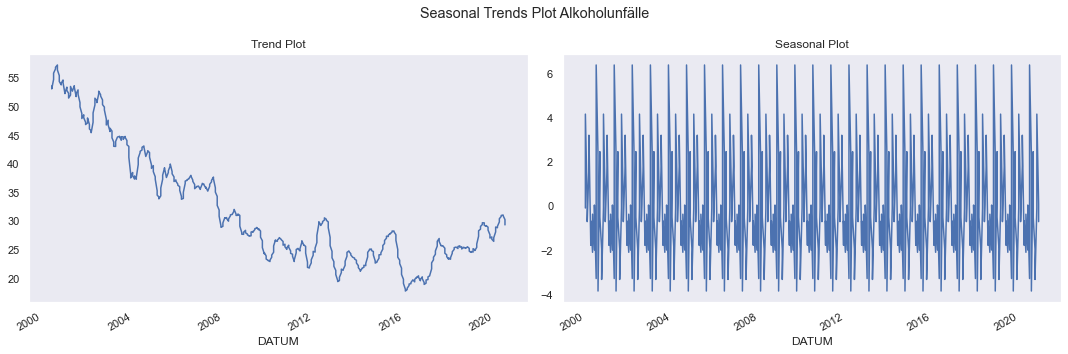

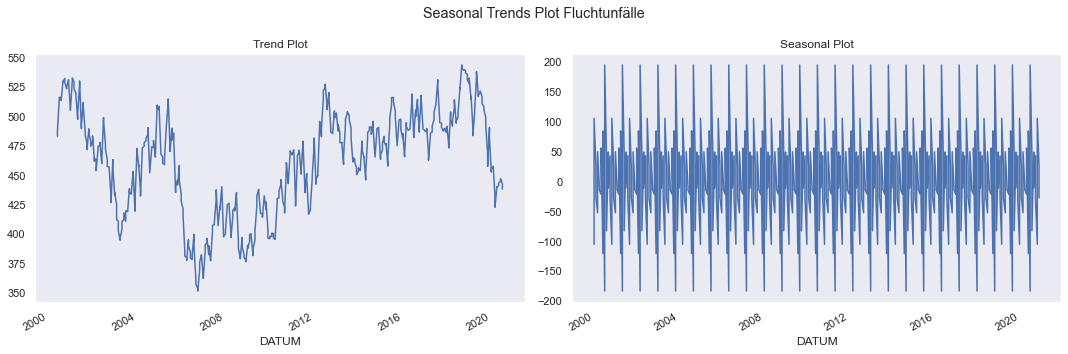

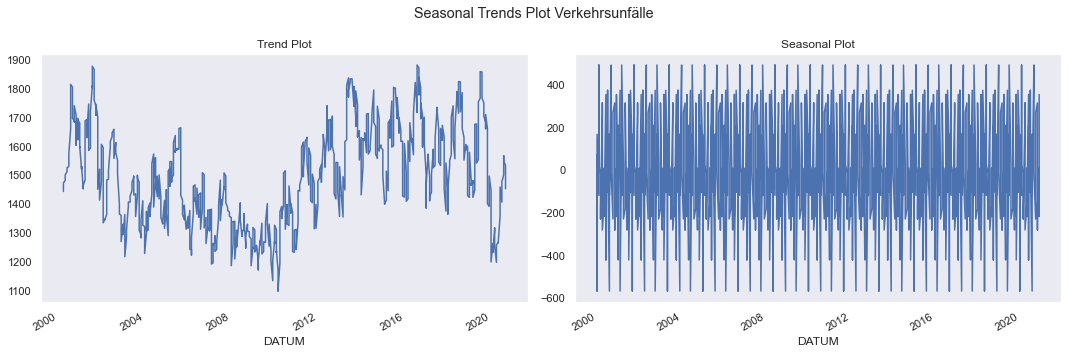

In [402]:
# Data Processing (Extracting Seasonal Trends)
# To do that we should start by converting our dates to timestamps in order to use seasonal_decompose
# We will combine Year (JAHR) and Months (MONAT) columns into a single column that we will call Date (DATUM)
from statsmodels.tsa.seasonal import seasonal_decompose

# Since we are missing the day I'll suppose that it's 1st of each Month
# Since MONAT has the year info we will use that MONAT[-2:] = Months and MONAT[:-2] = Year

dataset['DATUM'] = dataset['MONAT'].apply(lambda m:  pandas.to_datetime(m[:-2] + '-' + m[-2:] + '-01'))
dataset = dataset.drop(['MONAT', 'JAHR'], axis = 1) # We remove MONAT and JAHR since the info exists in our new column DATUM

MONATSZAHL = ['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle']


for x in MONATSZAHL:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Seasonal Trends Plot ' + x)
    analysis = dataset[dataset['MONATSZAHL'] == x]
    analysis = analysis[['DATUM','WERT']]
    analysis.sort_values(by='DATUM',inplace = True)
    analysis.set_index(['DATUM'], inplace = True)
    # Period = 20 since we have 20 years span so 20 "cycle"
    decompose_result_mult = seasonal_decompose(analysis, model="additive", period=20)
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    trend.plot(ax = axes[0]);
    axes[0].set_title("Trend Plot");
    seasonal.plot(ax = axes[1]);
    axes[1].set_title("Seasonal Plot");
    plt.tight_layout()

In [203]:
pip install statsmodels

You should consider upgrading via the 'C:\Users\Haytam\DPS-Challenge\Scripts\python.exe -m pip install --upgrade pip' command.
